# Ainu Audio Comparison (Simplified)

This lightweight notebook performs a minimal pronunciation similarity comparison:
1. Load one recording
2. Load and index sample set
3. Extract MFCC (+deltas) features
4. Compute DTW distance vs. each sample
5. Rank and visualize top match

For advanced analysis (embeddings, phonetics, widgets) see `01_ainu_audio_compare.ipynb`.

In [136]:
# 1) Minimal Imports
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import soundfile as sf  # noqa: F401 (placeholder for potential saving)

# Local utilities (reuse core logic)
import sys
ROOT = Path('..').resolve()
sys.path.append(str((ROOT / 'src').resolve()))
from audio_utils import load_audio, trim_silence, extract_features, zscore, dtw_distance, cosine_similarity_matrix

plt.rcParams['figure.dpi'] = 120
print('Imports complete.')

Imports complete.


## 2) Path Configuration and Parameters

In [137]:
# 2) Path Configuration and Parameters
DATA_DIR = (ROOT / 'data').resolve()
SAMPLES_DIR = DATA_DIR / 'samples' / 'vocabulary'
RECORDINGS_DIR = DATA_DIR / 'recordings'
OUTPUT_DIR = (ROOT / 'outputs').resolve()
RESULTS_DIR = OUTPUT_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Parameters
TARGET_SR = 16000
N_MFCC = 13
HOP_LENGTH = 160   # 10 ms at 16kHz
N_FFT = 400        # 25 ms window
TRIM_DB = 30.0
TOP_K = 5
DTW_METRIC = 'cosine'

AUDIO_EXTS = {'.wav', '.flac', '.mp3'}

print('Samples dir:', SAMPLES_DIR)
print('Recordings dir:', RECORDINGS_DIR)

Samples dir: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/samples/vocabulary
Recordings dir: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/recordings


## 3) Utility Helpers

In [138]:
# 3) Utility Helpers

def list_audio_files(folder: Path) -> List[Path]:
    return [p for p in folder.rglob('*') if p.suffix.lower() in AUDIO_EXTS]

def latest_file(folder: Path) -> Path | None:
    files = list_audio_files(folder)
    if not files:
        return None
    return max(files, key=lambda p: p.stat().st_mtime)

print('Helper functions ready.')

Helper functions ready.


## 4) Index Sample Audio Files

In [139]:
# 4) Index Sample Audio Files
sample_files = list_audio_files(SAMPLES_DIR)
if not sample_files:
    print(f"No sample files found in {SAMPLES_DIR}.")

import pandas as pd  # ensure available here

def infer_label_from_path(p: Path) -> str:
    try:
        return p.parent.name
    except Exception:
        return 'unknown'

samples_df = pd.DataFrame({
    'path': [str(p) for p in sample_files],
    'label': [infer_label_from_path(p) for p in sample_files],
    'relpath': [str(p.relative_to(SAMPLES_DIR)) for p in sample_files]
})
print(f"Indexed {len(samples_df)} sample files.")
samples_df.head(5)

Indexed 1 sample files.


,path,label,relpath
0,/home/nk21137/OneDrive/5years/graduation_resea...,vocabulary,manu.wav


## 5) Select and Load Recording

In [140]:
# 5) Select and Load Recording (override REC_FILE to force a file)
REC_FILE = latest_file(RECORDINGS_DIR)
if REC_FILE is None:
    print(f"No recording found in {RECORDINGS_DIR}. Add a WAV/FLAC/MP3 file.")
else:
    print('Using recording:', REC_FILE)

rec_audio = None
if REC_FILE is not None:
    rec_audio = load_audio(str(REC_FILE), target_sr=TARGET_SR, mono=True)
    peak = np.max(np.abs(rec_audio.y)) if rec_audio.y.size else 0
    if peak > 1e-6:
        rec_audio = rec_audio.__class__(y=rec_audio.y / peak * 0.89, sr=rec_audio.sr, path=rec_audio.path)
    print(f"Duration: {rec_audio.y.shape[0]/rec_audio.sr:.2f}s @ {rec_audio.sr} Hz")

Using recording: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/recordings/yabuki/manu.wav
Duration: 0.53s @ 16000 Hz


## 6) Trim Silence (Recording)

In [141]:
# 6) Trim Silence
trimmed_audio = None
if rec_audio is not None:
    trimmed_audio = trim_silence(rec_audio, top_db=TRIM_DB)
    dur = trimmed_audio.y.shape[0] / trimmed_audio.sr
    print(f'Trimmed duration: {dur:.2f}s (top_db={TRIM_DB})')

Trimmed duration: 0.45s (top_db=30.0)


## 7) Feature Extraction (MFCC + Deltas)

In [142]:
# 7) Feature Extraction
F_rec = None
if trimmed_audio is not None:
    F_rec = extract_features(trimmed_audio, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT,
                             add_deltas=True, add_prosody=False)
    print('Recording features:', F_rec.shape)

sample_feats = []
for p in tqdm(sample_files, desc='Sample features'):
    try:
        a = trim_silence(load_audio(str(p), target_sr=TARGET_SR))
        F = extract_features(a, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT,
                             add_deltas=True, add_prosody=False)
        sample_feats.append((str(p), F))
    except Exception as e:
        print('Failed:', p, e)
print(f'Extracted {len(sample_feats)}/{len(sample_files)} sample feature sets')

Recording features: (45, 39)


Sample features: 100%|██████████| 1/1 [00:00<00:00, 538.77it/s]

Extracted 1/1 sample feature sets


## 8) Z-Score Normalization

In [143]:
# 8) Z-Score Normalization
F_rec_z = zscore(F_rec) if F_rec is not None else None
sample_feats_z = [(path, zscore(F)) for path, F in sample_feats]
print('Normalized feature sets (recording + samples).')

Normalized feature sets (recording + samples).


## 9) DTW Similarity Scoring

In [144]:
# 9) DTW Similarity Scoring
dtw_rows = []
if F_rec_z is not None:
    for path, Fz in tqdm(sample_feats_z, desc='DTW scoring'):
        try:
            dist, _ = dtw_distance(F_rec_z, Fz, metric=DTW_METRIC)
            norm = F_rec_z.shape[0] + Fz.shape[0]
            score = dist / max(norm, 1)
            dtw_rows.append({
                'path': path,
                'label': infer_label_from_path(Path(path)),
                'dtw_dist': dist,
                'dtw_score': score,
                'n_frames_sample': Fz.shape[0]
            })
        except Exception as e:
            print('DTW failed:', path, e)
else:
    print('No recording features; skipping DTW.')
print(f'Computed DTW for {len(dtw_rows)} samples.')

DTW scoring: 100%|██████████| 1/1 [00:00<00:00, 2283.24it/s]

Computed DTW for 1 samples.


## 10) Build Ranked Results DataFrame

In [145]:
# 10) Build Ranked Results DataFrame
import pandas as pd
if dtw_rows:
    dtw_df = pd.DataFrame(dtw_rows).sort_values(['dtw_score','dtw_dist'], ascending=[True, True])
    display(dtw_df.head(TOP_K))
else:
    dtw_df = pd.DataFrame()
    print('No DTW results.')

,path,label,dtw_dist,dtw_score,n_frames_sample
0,/home/nk21137/OneDrive/5years/graduation_resea...,vocabulary,39.992948,0.412298,52


## 11) Simple Visualization

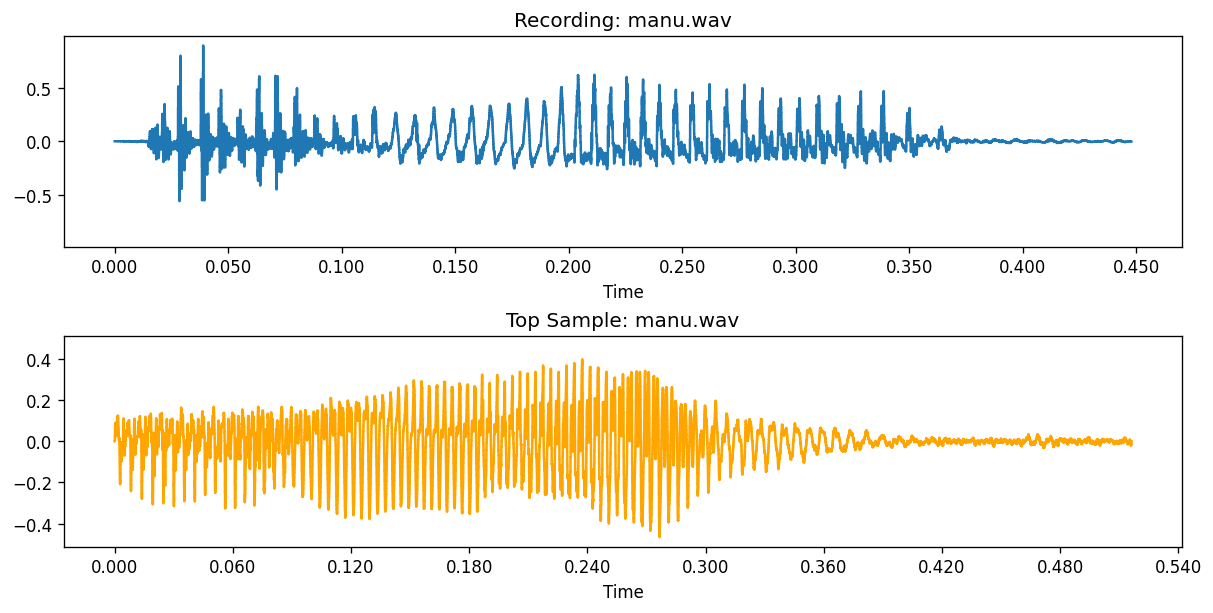

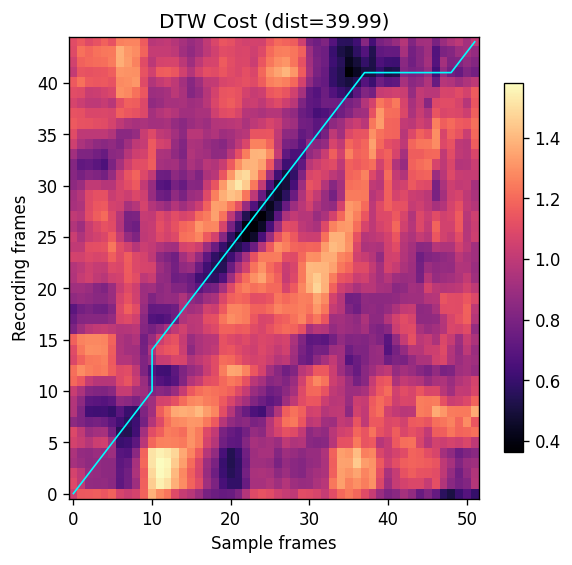

In [146]:
# 11) Simple Visualization
if not dtw_df.empty and rec_audio is not None and F_rec_z is not None:
    top_path = dtw_df.iloc[0]['path']
    samp = trim_silence(load_audio(top_path, target_sr=TARGET_SR))
    F_samp = extract_features(samp, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT,
                              add_deltas=True, add_prosody=False)
    F_samp_z = zscore(F_samp)

    # Waveforms
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)
    librosa.display.waveshow(trimmed_audio.y, sr=trimmed_audio.sr, ax=axes[0])
    axes[0].set_title(f'Recording: {Path(rec_audio.path).name}')
    librosa.display.waveshow(samp.y, sr=samp.sr, ax=axes[1], color='orange')
    axes[1].set_title(f'Top Sample: {Path(samp.path).name}')
    plt.show()

    # Cost matrix + DTW path
    cost = 1.0 - cosine_similarity_matrix(F_rec_z, F_samp_z)
    dist, path = dtw_distance(F_rec_z, F_samp_z, metric=DTW_METRIC)
    fig, ax = plt.subplots(figsize=(5.5, 5))
    im = ax.imshow(cost, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(f'DTW Cost (dist={dist:.2f})')
    ax.set_xlabel('Sample frames')
    ax.set_ylabel('Recording frames')
    ax.plot(path['index2'], path['index1'], color='cyan', linewidth=1)
    fig.colorbar(im, ax=ax, shrink=0.8)
    plt.show()
else:
    print('No visualization (missing recording or results).')

## 11b) Pitch Curve (Recording vs Top Sample)
Extract and plot fundamental frequency (F0) using librosa.yin for the trimmed recording and the current top-ranked sample. Unvoiced frames are shown as gaps. This is optional and may be noisy for low-quality or short clips.

/tmp/ipykernel_9057/4059552235.py:15: UserWarning: With fmin=50.000, sr=16000 and frame_length=400, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=80.000 or frame_length=641.
  f0_rec = librosa.yin(trimmed_audio.y, fmin=fmin, fmax=fmax, sr=trimmed_audio.sr, frame_length=frame_length, hop_length=hop)
/tmp/ipykernel_9057/4059552235.py:20: UserWarning: With fmin=50.000, sr=16000 and frame_length=400, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=80.000 or frame_length=641.
  f0_samp = librosa.yin(samp.y, fmin=fmin, fmax=fmax, sr=samp.sr, frame_length=frame_length, hop_length=hop)


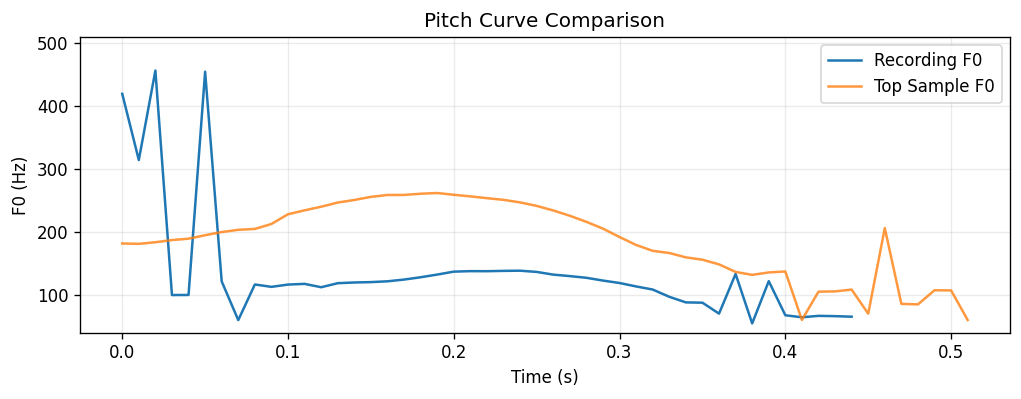

Saved pitch curve plot: /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/results/manu_pitch_curve.png


In [ ]:
# 11b) Pitch Curve Plot

if not dtw_df.empty and rec_audio is not None and F_rec_z is not None:
    try:
        top_path = dtw_df.iloc[0]['path']
        samp = trim_silence(load_audio(top_path, target_sr=TARGET_SR))
        # Parameters for F0 extraction
        fmin, fmax = 50, 500
        frame_length = N_FFT
        hop = HOP_LENGTH

        # Recording F0
        f0_rec = librosa.yin(trimmed_audio.y, fmin=fmin, fmax=fmax, sr=trimmed_audio.sr, frame_length=frame_length, hop_length=hop)
        f0_rec[f0_rec <= 0] = np.nan
        t_rec = np.arange(len(f0_rec)) * hop / trimmed_audio.sr

        # Sample F0
        f0_samp = librosa.yin(samp.y, fmin=fmin, fmax=fmax, sr=samp.sr, frame_length=frame_length, hop_length=hop)
        f0_samp[f0_samp <= 0] = np.nan
        t_samp = np.arange(len(f0_samp)) * hop / samp.sr

        fig, ax = plt.subplots(figsize=(10, 3.2))
        ax.plot(t_rec, f0_rec, label='Recording F0', color='tab:blue')
        ax.plot(t_samp, f0_samp, label='Top Sample F0', color='tab:orange', alpha=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('F0 (Hz)')
        ax.set_title('Pitch Curve Comparison')
        ax.set_ylim(fmin - 10, fmax + 10)
        ax.legend(loc='upper right')
        ax.grid(alpha=0.25)
        plt.show()

        # Save plot
        rec_name = Path(rec_audio.path).stem
        pitch_fig_path = RESULTS_DIR / f'{rec_name}_pitch_curve.png'
        fig.savefig(pitch_fig_path, dpi=140, bbox_inches='tight')
        plt.close(fig)
        print('Saved pitch curve plot:', pitch_fig_path)
    except Exception as e:
        print('Pitch curve generation failed:', e)
else:
    print('Pitch curve skipped (missing recording or ranking).')

## 11c) Approximate Formant Estimation (Experimental)
This cell estimates the first three formants (F1–F3) for the trimmed recording and top sample using a simple LPC method.
Limitations: Short frames and low sampling resolution can cause noisy estimates. Values are averaged across voiced frames only.

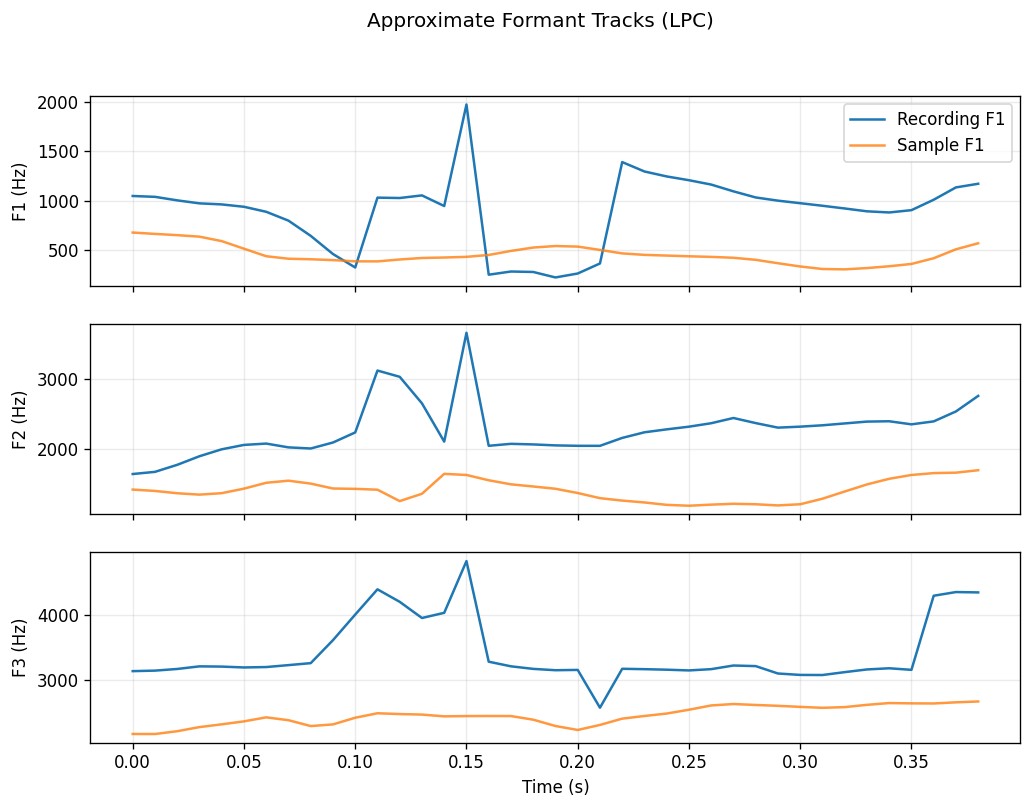

Recording formant median (Hz): {'F1_med': 971.9776866118415, 'F2_med': 2235.6515288595256, 'F3_med': 3191.7332448296374}
Sample formant median (Hz):    {'F1_med': 430.9895007039862, 'F2_med': 1410.9501526782537, 'F3_med': 2449.038537182734}
Saved formant summary JSON: /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/results/manu_formants.json


In [151]:
# 11c) Formant Estimation (LPC-based approximation)
import numpy as np
import librosa, math, json
from pathlib import Path

def estimate_formants(y, sr, frame_length=1024, hop_length=160, lpc_order=12, fmax=5000):
    """Estimate F1-F3 per frame using LPC roots.
    Returns arrays (F1, F2, F3) with NaN where unavailable."""
    if y.size < frame_length:
        return np.array([]), np.array([]), np.array([])
    # Pre-emphasis
    y_f = np.append(y[0], y[1:] - 0.97 * y[:-1])
    frames = librosa.util.frame(y_f, frame_length=frame_length, hop_length=hop_length).T
    window = np.hamming(frame_length)
    F1_list, F2_list, F3_list = [], [], []
    for fr in frames:
        fr_win = fr * window
        if not np.any(fr_win):
            F1_list.append(np.nan); F2_list.append(np.nan); F3_list.append(np.nan); continue
        try:
            # LPC coefficients
            a = librosa.lpc(fr_win, order=lpc_order)
            # Roots of LPC polynomial
            roots = np.roots(a)
            roots = [r for r in roots if np.imag(r) >= 0.01]  # positive freq only
            angs = np.angle(roots)
            freqs = sorted(angs * (sr / (2 * math.pi)))
            # Keep within range
            formants = [f for f in freqs if 90 <= f <= fmax]
            if len(formants) >= 3:
                F1_list.append(formants[0]); F2_list.append(formants[1]); F3_list.append(formants[2])
            else:
                # pad with NaN
                padded = formants + [np.nan] * (3 - len(formants))
                F1_list.append(padded[0]); F2_list.append(padded[1]); F3_list.append(padded[2])
        except Exception:
            F1_list.append(np.nan); F2_list.append(np.nan); F3_list.append(np.nan)
    return np.array(F1_list), np.array(F2_list), np.array(F3_list)

if not dtw_df.empty and rec_audio is not None and 'f0_rec' in globals():
    try:
        # Use voiced mask from pitch if available
        voiced_mask_rec = ~np.isnan(f0_rec)
        voiced_mask_samp = ~np.isnan(f0_samp) if 'f0_samp' in globals() else None
        # Choose frame_length separate from MFCC N_FFT for better resolution
        frame_length_form = 1024
        hop_form = HOP_LENGTH  # reuse hop

        F1r, F2r, F3r = estimate_formants(trimmed_audio.y, trimmed_audio.sr, frame_length=frame_length_form, hop_length=hop_form)
        samp = trim_silence(load_audio(dtw_df.iloc[0]['path'], target_sr=TARGET_SR))
        F1s, F2s, F3s = estimate_formants(samp.y, samp.sr, frame_length=frame_length_form, hop_length=hop_form)

        # Align lengths for plotting (truncate to min length)
        L = min(F1r.size, F1s.size)
        F1r, F2r, F3r = F1r[:L], F2r[:L], F3r[:L]
        F1s, F2s, F3s = F1s[:L], F2s[:L], F3s[:L]
        t = np.arange(L) * hop_form / trimmed_audio.sr

        fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
        for ax, Fr, Fs, label in zip(axes, [F1r, F2r, F3r], [F1s, F2s, F3s], ['F1','F2','F3']):
            ax.plot(t, Fr, label=f'Recording {label}', color='tab:blue')
            ax.plot(t, Fs, label=f'Sample {label}', color='tab:orange', alpha=0.8)
            ax.set_ylabel(f'{label} (Hz)')
            ax.grid(alpha=0.25)
        axes[0].legend(loc='upper right')
        axes[-1].set_xlabel('Time (s)')
        fig.suptitle('Approximate Formant Tracks (LPC)')
        plt.show()

        # Summaries (median across voiced frames)
        def voiced_median(arr):
            if len(arr) == 0:
                return np.nan
            return float(np.nanmedian(arr))

        rec_summary = {
            'F1_med': voiced_median(F1r),
            'F2_med': voiced_median(F2r),
            'F3_med': voiced_median(F3r)
        }
        samp_summary = {
            'F1_med': voiced_median(F1s),
            'F2_med': voiced_median(F2s),
            'F3_med': voiced_median(F3s)
        }
        print('Recording formant median (Hz):', rec_summary)
        print('Sample formant median (Hz):   ', samp_summary)

        # Save JSON
        rec_name = Path(rec_audio.path).stem
        form_json_path = RESULTS_DIR / f'{rec_name}_formants.json'
        with open(form_json_path, 'w', encoding='utf-8') as f:
            json.dump({'recording': rec_summary, 'sample': samp_summary}, f, indent=2)
        print('Saved formant summary JSON:', form_json_path)
    except Exception as e:
        print('Formant estimation failed:', e)
else:
    print('Formant estimation skipped (missing pitch or ranking).')

## 12) Save Top-K Results

In [150]:
# 12) Save Top-K Results
if not dtw_df.empty and rec_audio is not None:
    rec_name = Path(rec_audio.path).stem
    out_csv = RESULTS_DIR / f'{rec_name}_top{TOP_K}.csv'
    dtw_df.head(TOP_K).to_csv(out_csv, index=False)
    print('Saved ranking:', out_csv)

    # Save cost matrix of top-1 if not already captured
    try:
        top_path = dtw_df.iloc[0]['path']
        samp = trim_silence(load_audio(top_path, target_sr=TARGET_SR))
        F_samp = extract_features(samp, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                  add_deltas=True, add_prosody=False)
        F_samp_z = zscore(F_samp)
        cost = 1.0 - cosine_similarity_matrix(F_rec_z, F_samp_z)
        dist, path = dtw_distance(F_rec_z, F_samp_z, metric=DTW_METRIC)
        fig, ax = plt.subplots(figsize=(5.5, 5))
        im = ax.imshow(cost, origin='lower', aspect='auto', cmap='magma')
        ax.plot(path['index2'], path['index1'], color='cyan', lw=1)
        ax.set_title(f'Top1 Cost (dist={dist:.2f})')
        fig.colorbar(im, ax=ax, shrink=0.8)
        fig_path = RESULTS_DIR / f'{rec_name}_top1_cost.png'
        fig.savefig(fig_path, dpi=140)
        plt.close(fig)
        print('Saved cost matrix plot:', fig_path)
    except Exception as e:
        print('Plot save failed:', e)
else:
    print('Nothing to save.')

Saved ranking: /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/results/manu_top5.csv
Saved cost matrix plot: /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/results/manu_top1_cost.png
